## Avatar generator with generative deep learning

https://github.com/dtrckd/simplon_datai_2020/blob/master/brief_10/brief.md

Afin de proposer un service de génération automatique d'avatar, la société Dupond Père et Fils vous mandate afin de développer l'application.

Pour ce faire, vous disposez d'un jeux de données d'avatars disponible ici (utilisez celui de **10000 images**) : 

    https://google.github.io/cartoonset/download.html 

L'opérateur souhaite utilisé une technologie de modèle profond génératif de type **GAN**. De plus, celui-ci dispose de ressource limité, il vous est demandé de redimensioner les images en **128x128 pixels.**

On vous demande de réaliser les éléments suivants :

- désigner le système d'apprentissage afin de produire un modèle entrainé pour le service de génération d'avatar

- créer une application web permettant de générer des avatars:

l'application affichera par défaut une grille ou seras affiché par défaut sur une même page **10x8 avatars** (10 ligne 8 colonne).
**un bouton permettant de régénérer les avatars.**

**Bonus : Développer un modèle alternatif utilisant un modèle type Variational Auto-Encoder (VAE)**

### Download unzip data

In [ ]:
import os

if 'datas' not in os.listdir():
    os.makedirs("datas")


In [ ]:
!gsutil cp gs://cartoonset_public_files/cartoonset10k.tgz /content/datas/cartoonset10k.tgz

Copying gs://cartoonset_public_files/cartoonset10k.tgz...
| [1 files][454.6 MiB/454.6 MiB]                                                
Operation completed over 1 objects/454.6 MiB.                                    


In [ ]:
!tar -xzvf "/content/datas/cartoonset10k.tgz" -C "/content/datas/"

Streaming output truncated to the last 5000 lines.
cartoonset10k/cs11130198548099864740.csv
cartoonset10k/cs11130198548099864740.png
cartoonset10k/cs11130522928710913906.csv
cartoonset10k/cs11130522928710913906.png
cartoonset10k/cs11130692035407747496.csv
cartoonset10k/cs11130692035407747496.png
cartoonset10k/cs1113080672465802980.csv
cartoonset10k/cs1113080672465802980.png
cartoonset10k/cs11131138722323947780.csv
cartoonset10k/cs11131138722323947780.png
cartoonset10k/cs1113121412202668922.csv
cartoonset10k/cs1113121412202668922.png
cartoonset10k/cs11131333133753359573.csv
cartoonset10k/cs11131333133753359573.png
cartoonset10k/cs1113143340294813643.csv
cartoonset10k/cs1113143340294813643.png
cartoonset10k/cs11131732994961040179.csv
cartoonset10k/cs11131732994961040179.png
cartoonset10k/cs1113191746674328122.csv
cartoonset10k/cs1113191746674328122.png
cartoonset10k/cs11131958805482037869.csv
cartoonset10k/cs11131958805482037869.png
cartoonset10k/cs1113266829786440678.csv
cartoonset10k/c

### Veille **GAN** -> Generative Adversarial Networks

https://keras.io/examples/generative/dcgan_overriding_train_step/

https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/

### Import

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

### Data Import

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
          "/content/datas", 
          label_mode=None, 
          image_size=(128, 128), 
          batch_size=32
          )

dataset = dataset.map(lambda x: x / 255.0)

Found 10000 files belonging to 1 classes.


Affichons un élèment de ce dataset

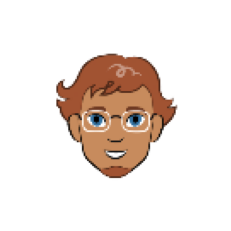

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### Create the discriminator

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)           

### Create the Generator

In [ ]:
latent_dim = 256

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16 * 16 * 128),
        layers.Reshape((16, 16, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32768)             8421376   
_________________________________________________________________
reshape_4 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 64, 64, 256)       524544    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 128, 128, 512)     20

### Class GAN



In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

### Class GANMonitor

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save('generator.h5')
        self.model.discriminator.save('discriminator.h5')
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

### Train the model

In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [ ]:

gan.fit(
    dataset, epochs=20, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)])

Epoch 1/20
313/313 [==============================] - 175s 557ms/step - d_loss: 0.1634 - g_loss: 3.1162
Epoch 2/20
313/313 [==============================] - 176s 559ms/step - d_loss: 0.1589 - g_loss: 3.1342
Epoch 3/20
313/313 [==============================] - 176s 559ms/step - d_loss: 0.1408 - g_loss: 3.2116
Epoch 4/20
313/313 [==============================] - 176s 559ms/step - d_loss: 0.1464 - g_loss: 3.2739
Epoch 5/20
313/313 [==============================] - 176s 560ms/step - d_loss: 0.1598 - g_loss: 3.1915
Epoch 6/20
313/313 [==============================] - 176s 560ms/step - d_loss: 0.1267 - g_loss: 3.3301
Epoch 7/20
313/313 [==============================] - 176s 560ms/step - d_loss: 0.1543 - g_loss: 3.3136
Epoch 8/20
313/313 [==============================] - 176s 559ms/step - d_loss: 0.1340 - g_loss: 3.4005
Epoch 9/20
313/313 [==============================] - 176s 559ms/step - d_loss: 0.1388 - g_loss: 3.3157
Epoch 10/20
313/313 [==============================] - 176s 560m

In [ ]:
gan.save_weights('gan_model.h5')

NameError: ignored

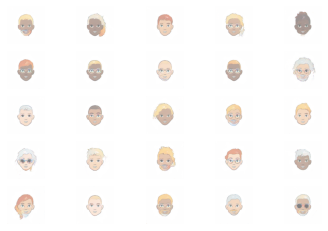

In [ ]:
import matplotlib.pyplot as pyplot


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input
 
# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = keras.models.load_model('generator.h5')
# generate images
latent_points = generate_latent_points(256, 25)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 5)